## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd


import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os
import time
import soundfile as sf

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, symbol_to_id
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict

import torch.nn.utils.prune as prune
from torch.nn import functional as F

from sklearn.metrics.pairwise import cosine_similarity as cs


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

loaded = False



In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
# hparams.end_symbols_ids = [symbol_to_id[s] for s in '?!.']
# hparams.use_gst = False

In [4]:
checkpoint_path = "outdir/checkpoint_500"
model = Tacotron2(hparams).cuda()
model.load_state_dict(torch.load(checkpoint_path)['state_dict']) #,map_location=torch.device('cpu')
_ = model.cuda().eval().half()

In [17]:
ref_mel = get_mel('test/test2.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

torch.float16 torch.Size([1, 80, 134])


In [18]:
print(ref_mel)

tensor([[[-4.2656, -4.9258, -4.9648,  ..., -6.1367, -5.4766, -3.4688],
         [-3.8984, -3.9453, -4.0117,  ..., -4.1016, -4.3281, -2.9551],
         [-5.2344, -4.1680, -4.5234,  ..., -1.5586, -1.5879, -1.9746],
         ...,
         [-5.0234, -5.2305, -6.0547,  ..., -7.7148, -8.4453, -8.4062],
         [-4.6875, -5.0391, -5.7891,  ..., -8.0703, -8.4219, -8.7266],
         [-5.2969, -5.3555, -5.8750,  ..., -8.2344, -8.7500, -9.1953]]],
       device='cuda:0', dtype=torch.float16)


In [19]:

text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
# text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не м+ожет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
# text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы? сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
# text = "Как пройти в дом?"
# text = "В+ыйду,,,,,,, н+очью,,, в п+оле,,, с кон+ем"
text = "Н+очь, +улица, фон+арь, апт+ека. Бессм+ысленный, и т+усклый св+ет. Жив+и ещ+е х+оть ч+етверть в+ека - Вс+ё б+удет т+ак. Исх+ода н+ет."
# text = "Ночь, улица, фонарь, аптека. Бессмысленный, и тусклый свет. Жив+и еще хоть четверть века - Все будет так. Исхода нет."
# text = "Игра - тип осмысленной непродуктивной деятельности, где мотив лежит не в её результате, а в самом процессе. Также термин игра используют для обозначения набора предметов или программ, предназначенных для подобной деятельности."
# text = "Прижм+ись к+о мн+е кр+епче и бл+иже. Не ж+ил я,, блужд+ал ср+едь чуж+их. О с+он м+ой,, Я н+овое в+ижу, В бред+у поцел+уев тво+их!"

# text = "Тогд+а почем+у ж+е я ощущ+аю себ+я н+а гр+ани физ+ической катастр+офы?"
# text ="Ты согласен?"
# text = "Здр+аствуйте, мен+я зов+ут Андр+ей Никиш+аев, я с+иньер архит+ектор в комп+ании манив+ео. П+о мо+им д+анным у в+ас не закр+ытый кред+ит на с+умму в+осемдесят тр+и т+ысячи тр+иста шестдес+ят тр+и гр+ивны. Н+ужно погас+ить!"
# text = "С к+аждым дн+ем весн+ы стан+овится вс+е тепл+ее, а +это р+адость для к+аждого вод+ителя."
# text = "Молод+ой парн+ишка Т+анг С+ан одн+ажды оступ+ился и сл+едуя сво+им жел+аниям и пр+ихотям вор+ует секр+етные уч+ения в своей школе боевых искусств."

print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Sn+och', +ulitsa, fon+ar', apt+eka. bessm+yslennyi, i t+usklyi sv+et. zhiv+i eshch+e kh+ot' ch+etvert' v+eka - vs+io b+udet t+ak. iskh+oda n+et.E
[[12 27 40 28 16 21  3  6 11 40 34 25 22 33 32 14  6 11 19 28 27 40 14 31
   3  6 11 14 29 33 40 18 24 14  7 11 15 18 32 32 26 40 38 32 25 18 27 27
  38 22  6 11 22 11 33 40 34 32 24 25 38 22 11 32 35 40 18 33  7 11 39 21
  22 35 40 22 11 18 32 21 16 21 40 18 11 24 21 40 28 33  3 11 16 21 40 18
  33 35 18 31 33  3 11 35 40 18 24 14 11  1 11 35 32 40 22 28 11 15 40 34
  17 18 33 11 33 40 14 24  7 11 22 32 24 21 40 28 17 14 11 27 40 18 33  7
  13]]


In [20]:
def model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = ('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
    return size

In [21]:


# bit8_model = torch.quantization.quantize_dynamic(
#         model, {torch.nn.LSTM, torch.nn.Linear, torch.nn.LSTMCell, torch.nn.GRUCell}, dtype=torch.qint8
# )

# print(model_size(bit8_model))
# for name, module in bit8_model.named_modules():
#     if isinstance(module, torch.nn.Conv1d):
#         prune.l1_unstructured(module, name='weight', amount=0.2)
#     elif isinstance(module, torch.nn.Linear):
#         prune.l1_unstructured(module, name='weight', amount=0.2)
   
# print(model_size(bit8_model))

In [22]:
%%time
# np.random.seed(16)

z_scale = np.ones(32, dtype=np.float32)
z_scale[7] = 1.0

_, mel_outputs, mel_outputs_postnet, _, alignments, emb2 = model.inference(sequence,seed=1234,scale=2.0, reference_mel=ref_mel)

CPU times: user 818 ms, sys: 9.19 ms, total: 827 ms
Wall time: 826 ms


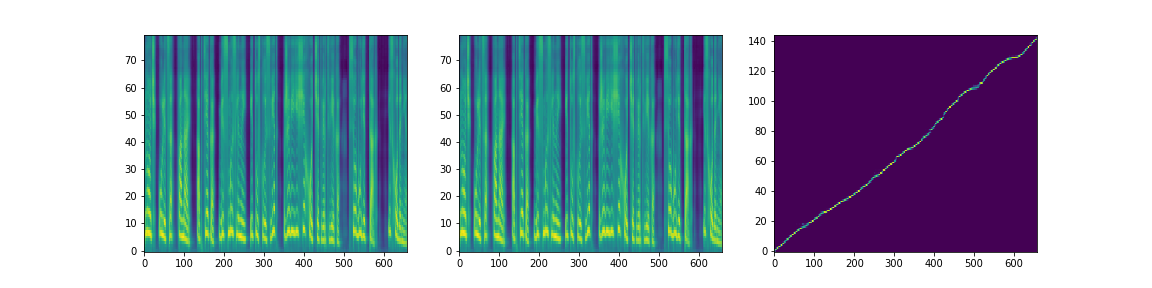

In [23]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [24]:
emb2

tensor([[[-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         ...,
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<RepeatBackward>)

In [25]:
emb2

tensor([[[-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         ...,
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261],
         [-0.0212,  0.0045, -0.0433,  ...,  0.1133,  0.0682,  0.1261]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<RepeatBackward>)

In [26]:
loaded = False
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

if not loaded:
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    
#     generator = torch.quantization.quantize_dynamic(
#         generator, {torch.nn.LSTM, torch.nn.Linear, torch.nn.LSTMCell, torch.nn.GRUCell}, dtype=torch.qint8
#     )
    loaded=True

def inference(mel, generator):
    

    
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    


Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...


In [27]:
s = time.perf_counter()
mel = mel_outputs_postnet.type(torch.float32)
print(time.perf_counter()-s)
            

0.03594236099161208


In [28]:
%%time
audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)  

CPU times: user 404 ms, sys: 4.31 ms, total: 408 ms
Wall time: 407 ms


In [75]:
%%time
# np.random.seed(16)
for i in range(32):
    z_scale = np.ones(32, dtype=np.float32)
    z_scale[10] = 1.3

    _, mel_outputs, mel_outputs_postnet, _, alignments, emb2 = model.inference(sequence,seed=1234,z_scale=z_scale, reference_mel=ref_mel)
    mel = mel_outputs_postnet.type(torch.float32)
    audio = inference(mel, generator)
    sf.write('res/z_%s.wav' % i, audio*0.0002, 22050)

tensor([[ 0.1368,  0.5962, -0.1841,  0.6860, -0.4175, -0.3042, -0.4607,  1.0156,
         -0.5020, -0.3806,  0.4875,  0.9399,  0.8901, -0.0493, -0.1998, -0.6240,
          1.3857, -2.2285, -0.2086, -0.3665,  0.5903,  0.5225, -0.3538,  1.9990,
         -0.5425, -1.2705, -1.9961,  0.4502, -0.3403, -0.6719, -1.5938, -1.3701]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
tensor([[-0.5239, -0.9795, -0.5215,  0.8008, -2.4219,  0.8452,  1.2451, -0.2338,
          0.2925,  0.1605,  0.0280,  0.5942,  1.0488, -0.1068, -1.1074,  0.0426,
         -0.7769,  0.4915,  0.8179,  1.7656,  0.0034,  1.5703,  0.6782, -0.7183,
         -1.6758, -0.2544,  1.5547, -0.7642,  0.3567, -1.7705, -0.7563, -1.1641]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
tensor([[ 1.6787,  0.2754, -0.0305,  0.2355, -1.0117,  1.3672,  1.3584,  0.5767,
          0.8330,  0.0833,  0.2445,  1.5166, -0.5981,  0.7251, -0.8589,  0.5581,
          0.2493,  0.5259, -0.6987,  0.7144, -1.

tensor([[-1.0566,  2.8535,  0.3379, -0.3015,  0.9092, -1.6934,  1.2598, -0.1136,
          0.0364, -0.1814, -0.1284, -1.2646,  0.0532,  1.3291, -0.8247, -0.8262,
         -0.3765,  0.9805,  0.2947, -1.3818,  0.1127,  0.0951,  1.2451,  1.2598,
         -0.2559, -1.2568, -0.0342,  0.4363, -0.5220,  0.0724, -0.1642, -1.5928]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
tensor([[-0.9717, -0.3008, -2.1992, -0.2312,  0.8423, -1.6348,  0.8872, -1.6416,
         -0.1344,  0.6899, -0.8027,  0.1880,  2.4473,  0.8848, -0.0884, -0.6577,
         -0.4961, -0.9980,  0.3672, -1.9443,  1.0420, -0.7720, -1.4795,  1.5420,
          1.1553, -2.1035,  0.6597,  0.3862,  0.2035,  1.2422, -0.2795,  0.4827]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
tensor([[-1.3662, -0.6064,  1.3359,  1.5205, -0.3784,  1.0137,  1.2266, -1.1289,
          0.5083,  0.3037, -0.5439,  0.2164,  2.3789,  1.2949,  0.5596, -0.4507,
         -0.0082, -0.4131, -0.9702, -0.4038,  1.

In [ ]:
norm = F.normalize(vect, dim=1).detach().cpu().numpy()
res =  cs(norm, norm)
res

In [ ]:
(emb1.detach().cpu().numpy()[0][0] - emb2.detach().cpu().numpy()[0][0])

In [ ]:
print(emb1.detach().cpu().numpy().shape)